# PyTorch Tutorial by Modar

Basic PyTorch classification tutorial with links and references to useful materials to get started ([Gist link](https://nbviewer.jupyter.org/gist/ModarTensai/b081dcf6c87f9134f29abe3a77be1ab5)). 
This tutorial was presented on the 6th of August 2018 as part of the [weekly meetings](https://github.com/IVUL-KAUST/GroupReading) of [IVUL-KAUST](http://ivul.kaust.edu.sa) research group.

## Resources
 - [PyTorch Tutorials Page](https://pytorch.org/tutorials/)
 - [PyTorch Documentation](https://pytorch.org/docs/stable/index.html)
 - [PyTorch Examples](https://github.com/pytorch/examples)

## PyTorch as GPU accelerated Numpy

 - [Most useful functions](https://pytorch.org/docs/stable/torch.html)
 - [torch.tensor == np.ndarray](https://pytorch.org/docs/stable/tensors.html)
     - default types and auto-casting
     - shapes and dimensions
     - in-place vs output operations
 - [Moving into any GPU](https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html#sphx-glr-beginner-blitz-data-parallel-tutorial-py)

 ## PyTorch for Deep Learning
 
 - [Autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#)
 - [Modules](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) (Neural Networks)
 - [Dealing with Data](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
   - [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder)
   - [Transforms](https://pytorch.org/docs/stable/torchvision/transforms.html)
   - [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)
   - [Pinned vs. Pageable Memory](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) (for CPU-GPU data transfer)
 - [Optimizers](https://pytorch.org/docs/stable/optim.html)

## High-Level PyTorch Wrappers

There exists high-level APIs for PyTorch analogous to Keras for Tensorflow such as:

 - [torchsample](https://github.com/ncullen93/torchsample)
 - [ignite](https://github.com/pytorch/ignite) (the official one)
 - [torchtools](https://github.com/Time1ess/torchtools)
 - [beauty-net](https://github.com/cms-flash/beauty-net)
 
Also, it is not that hard to use tensorboard with PyTorch:

 - [simple example](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/04-utils/tensorboard)
 - [tensorbaordX](https://github.com/lanpa/tensorboardX)

## Example: Classification on Kaggle's Dogs vs. Cats

You can use this official [~100 lines example](https://github.com/pytorch/examples/blob/master/mnist/main.py) of MNIST classification as a reference.

### Import the relevant libraries

In this example, we will only use `torch` and `torchvision` and we won't be using any high-level API because we want to demonstrate the power of PyTorch at its core. In fact, we will be building something similar to a high-level API ourselves.

In [1]:
import importlib
import tensorflow as tf  # to visualize training summaries with tensorboard

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms, datasets

# for reproducibility
torch.manual_seed(0)

# a utility function to print the progress of a for-loop
# don't worry about this bit because it is not part of the tutorial
# it is recommended that you install `tqdm` package
def _verbosify(iterable):
    # shows only the iteration number and how many iterations are left
    try:
        len_iterable = len(iterable)
    except Exception:
        len_iterable = None
    for i, element in enumerate(iterable, 1):
        if len_iterable is None:
            print('\rIteration #{}'.format(i), end='')
        else:
            print('\rIteration #{} out of {} iterations [Done {:.2f}%]'.format(
                i, len_iterable, 100 * i / len_iterable), end='')
        yield element
    print('\r', end='', flush=True)

def verbosify(iterable, **kwargs):
    # try to use tqdm (shows the speed and the remaining time left)
    if importlib.util.find_spec('tqdm') is not None:
        tqdm = importlib.import_module('tqdm').tqdm
        if 'file' not in kwargs:
            kwargs['file'] = importlib.import_module('sys').stdout
        if 'leave' not in kwargs:
            kwargs['leave'] = False
        return tqdm(iterable, **kwargs)
    else:
        return iter(_verbosify(iterable))

# try out this example (uncomment to test):
# for i in verbosify(range(10000000)):
#     pass

### Prepare the dataset [goal: defining `train_loader` and `valid_loader`]

I strongly recommend that you follow [this tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) for a more comprehensive understanding of how to deal with data. 

#### 1 - Obtain the dataset

You can find the Dogs vs. Cats dataset [here](https://www.kaggle.com/c/dogs-vs-cats/data). However, you can use your own dataset but to use [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) you need to make sure that the dataset is in a folder where each subfolder is a class label that contains all the images of that class. There are also utility functions in `torchvision` that downloads common datasets like MNIST and CIFAR10 under `torchvision.datasets` (e.g. `torchvision.datasets.MNIST`).

After you download the Dogs vs. Cats dataset you would get `all.zip` file, unzip it using:
```shell
sudo apt-get install unzip
unzip all.zip -d all
cd all
unzip train.zip
cd train
```

All the images are named as `[dog|cat].<index>.jpg` but we need to put them in sperate folders `{cat, dog}` as follows:
```shell
mkdir dog cat
mv dog.* dog
mv cat.* cat
```

#### 2 - Define the transforms

In PyTorch, we call the input to your model `data` and the output `target`. When we read images from a folder, they are read as `PIL` images but in order to feed them as `data` to our model, they need to be transformed to PyTorch tensors with correct size and normalization. This is why we will create a list of transformation functions for the images, each of which will operate on the output of the previous function while the first function will operate on a single `PIL` image. You can also create transformation functions for the output labels called `target_transform` if needed.

In [2]:
train_transform = transforms.Compose([
        transforms.Resize(224),             # takes PIL image as input and outputs PIL image
        transforms.RandomResizedCrop(224),  # takes PIL image as input and outputs PIL image
        transforms.RandomHorizontalFlip(),  # takes PIL image as input and outputs PIL image
        transforms.ToTensor(),              # takes PIL image as input and outputs torch.tensor
        transforms.Normalize(mean=[0.4280, 0.4106, 0.3589],  # takes tensor and outputs tensor
                             std=[0.2737, 0.2631, 0.2601]),  # see next step for mean and std
    ])
valid_transform = transforms.Compose([  # for validation we don't randomize or augment
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4280, 0.4106, 0.3589],
                             std=[0.2737, 0.2631, 0.2601]), 
    ])

#### 3 - Create the dataset

In [3]:
# Just implement __getitem__ and __len__
class DummyDataset(torch.utils.data.Dataset):
    def __init__(self, size=(3, 224, 224), num_samples=1000, num_classes=3):
        self.images = torch.randn(num_samples, *size)
        self.labels = torch.randint(0, num_classes, (num_samples,))
        # this dataset, doesn't need transforms
        # because it is already in the correct size and format

    def __getitem__(self, index):
        return self.images[index, ...], self.labels[index]

    def __len__(self):
        return self.images.size(0)

# Or, we can use `torchvision.datasets.ImageFolder`
dataset = datasets.ImageFolder(root='./all/train/',
                               transform=train_transform)

# here you should split this dataset into training and validation
split_frac = 0.1  # the ratio of images in the validation set
dataset_length = len(dataset)
train_length = int(dataset_length * (1 - split_frac))
valid_length = dataset_length - train_length
train_set, valid_set = torch.utils.data.random_split(dataset, [train_length, valid_length])

In [4]:
# getting the mean and std of the images (assuming that you have enough memory)

# pixels_list = [img.view(3, -1) for img, label in \  # this will take a while
#                datasets.ImageFolder(root='all/train', transform=valid_transform)]  
# pixels = torch.cat(pixels_list, dim=-1)
# pixels_mean = pixels.mean(dim=-1)
# pixels_std = pixels.std(dim=-1)
# print(pixels_mean)  # Out: tensor([0.4280, 0.4106, 0.3589])
# print(pixels_std)   # Out: tensor([0.2737, 0.2631, 0.2601])

# if you don't have sufficient memory, you can compute mean as a running average
# and std as described here: https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance

#### 4 - Define the loaders

In [5]:
# create the torch.utils.data.DataLoader which will do the loading
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=128,
                                           pin_memory=True,   # set True if you are using CUDA
                                           num_workers=4,     # set 0 if training using CPU
                                           shuffle=True,
                                           drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_set,
                                           batch_size=256,
                                           pin_memory=True,
                                           num_workers=4,
                                           shuffle=False)
# Note: look up the rest of the parameters of DataLoader
#       some of the interesting ones are `sampler` and `collate_fn`.

### Define the model [goal: defining `Net`]

Please, refer to the official implementation of AlexNet [here](https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py) for a nicer style of defining an `nn.Module` that uses `nn.Sequential` which itself is a subclass of `nn.Module`. It will introduce you to `nn.Sequential` and the concept of defining a module using submodules.

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # define all the parameters of the model here
        # Note: All the layers and modules have to be direct
        #       attributes of Net to be included in training (e.g. self.conv1).
        #       To add them manually: `self.add_module(name, module)`.
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(64, 64, kernel_size=5)
        self.conv4 = nn.Conv2d(64, 20, kernel_size=5)
        self.fc1 = nn.Linear(2000, 1024)  # assumes the input is 224x224
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        # define the forward pass here
        # Note: PyTorch will complain if you tried to do operations between tensors that don't
        #       have the same dtype and/or device but it will allow scalar tensor operations.
        #       Be wary of operations using scalars because it is a big source of errors.
        #       Native Python scalars are mostly fine but Numpy scalars are problematic:
        #       E.g., `np.array([1.])[0] * torch.tensor(2, device='cuda')` will be in 'cpu'.
        #       Always put the scalars in `torch.tensor` to know when you are mixing stuff.
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.relu(F.max_pool2d(self.conv4(x), 2))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

### Implement the training procedure [goal: defining `full_epoch()`]

We need to implement a function, called `full_epoch()`, that performs a single complete epoch on a given dataset and returns some computed metrics (e.g., loss and accuracy). It will take as input the model, the data loader, the device to do the operations on and optionally an optimizer. If the optimizer is provided, it will do a training epoch, otherwise it will do a validation epoch. Here, we will also implement a helper function called `process()`, for modularity purposes only, that processes a single input batch at a time and it will be called by `full_epoch()` at each iteration. Usually, you would only need to modify `process()`.

In [7]:
def softmax_cross_entropy(output, target):
    # more efficient than `F.cross_entropy(F.softmax(output), target)`
    return F.nll_loss(F.log_softmax(output, dim=1), target)

def accuracy(output, target):
    predictions = output.max(1, keepdim=True)[1]
    return predictions.eq(target.view_as(predictions)).sum()

def process(model, data, target, optimizer=None):
    '''Perform the forward and backward passes on the given data.
    
    Args:
        model: An `nn.Module` or a function to process `data`.
        data: The desired input to `model` (e.g., a batch of images).
        target: The desired output of `model` (e.g., ground truth labels).
        optimizer: To perform the backward pass.
        
    Returns:
        A `dict` of collected metrics.
    '''
    # compute the loss
    output = model(data)  # logits
    loss = softmax_cross_entropy(output, target)
    
    # if training, update the weights
    if optimizer is not None:
        # you need to zero_out the gradients of all the parameters
        optimizer.zero_grad()
        # accumlate the gradients with a backward pass
        loss.backward()
        # update the parameters with the gradients
        optimizer.step()
    
    # save the metrics
    metrics = {
        'loss': loss.item() * len(data),
        'accuracy': accuracy(output, target).item(),
    }
    return metrics

def full_epoch(model, data_loader, device, optimizer=None):
    '''Perform a single epoch.
    
    Args:
        model: An `nn.Module` or a function to process `data`.
        data_loader: A 'torch.utils.data.DataLoader'.
        device: On which device to perfrom the epoch.
        
    Returns:
        A `dict` of collected metrics.
    '''
    # Change model.training to True and False accordingly
    if optimizer is None:
        model.eval()
    else:
        model.train()
    model.to(device)
    total_count = 0
    accumulated_metrics = {}
    for data, target in verbosify(data_loader):
        # process the batch [data (images) and target (labels)]
        metrics = process(model, data.to(device), target.to(device), optimizer)
        # accumlate the metrics
        total_count += len(data)
        for metric, value in metrics.items():
            if metric not in accumulated_metrics:
                accumulated_metrics[metric] = 0
            accumulated_metrics[metric] += value
    # compute the averaged metrics
    for metric in accumulated_metrics:
        accumulated_metrics[metric] /= total_count
    return accumulated_metrics

### Train a model [goal: defining `train()` and running it]

But first, we will implement a generic `train()` function.

In [8]:
def train(model, device, num_epochs, optimizer, train_loader, valid_loader,
          scheduler=None, patience=10, load=None, save=None, log_dir=None):
    '''Train a model for a certain number of epochs.
    
    Args:
        model: An `nn.Module` or a function to process the batches form the loaders.
        device: In which device to do the training.
        num_epochs: Number of epochs to train.
        optimizer: An `torch.optim.Optimizer` (e.g. SGD).
        train_loader: The `torch.utils.data.DataLoader` for the training dataset.
        valid_loader: The `torch.utils.data.DataLoader` for the validation dataset.
        scheduler: The learning rate scheduler.
        patience: The number of bad epochs to wait before early termination.
        load: Reinitialize the model and its hyper-parameters from this `*.pt` checkpoint file.
        save: The `*.pt` checkpoint file to save all the parameters of the trained model.
        log_dir: The directory to which we want to save tensorboard summaries.
        
    Returns:
        The best state of the model during training (at the maximum validation loss).
    '''
    # try to resume from a checkpoint file if `load` was provided
    if load is not None:
        try:
            best_state = torch.load(load)
            model.load_state_dict(best_state['model'])
            optimizer.load_state_dict(best_state['optimizer'])
            scheduler.load_state_dict(best_state['scheduler'])
        except FileNotFoundError:
            msg = 'Couldn\'t find checkpoint file! {} (training without reinitialization)'
            print(msg.format(load))
            load = None

    # otherwise, start from the current initialization
    if load is None:
        best_state = {
            'epoch': -1,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'loss': float('inf'),
        }
    
    model.to(device)
    num_bad_epochs = 0
    for epoch in range(best_state['epoch'] + 1, num_epochs):
        # train and validate
        train_metrics = full_epoch(model, train_loader, device, optimizer)
        valid_metrics = full_epoch(model, valid_loader, device)  # will not do backward pass

        # get the current learing rate
        learning_rate = optimizer.param_groups[0]['lr']
        # Note: an nn.Module can have multiple param_groups
        #       each of which can be assigned a different learning rate
        #       but by default we have a single param_group.

        # reduce the learning rate according to the `scheduler` policy
        if scheduler is not None:
            scheduler.step(valid_metrics['loss'])

        # print the progress
        print('Epoch #{}: [train: {:.2e} > {:.2f}%][valid: {:.2e} > {:.2f}%] @ {:.2e}'.format(
            epoch, train_metrics['loss'], 100 * train_metrics['accuracy'],
            valid_metrics['loss'], 100 * valid_metrics['accuracy'], learning_rate,
        ))

        # save tensorboard summaries
        if log_dir is not None:
            # create the summary writer only the first time
            if not hasattr(log_dir, 'add_summary'):
                log_dir = tf.summary.FileWriter(log_dir)
            summaries = {
                'learning_rate': learning_rate,
                'train/loss': train_metrics['loss'],
                'train/accuracy': train_metrics['accuracy'],
                'valid/loss': valid_metrics['loss'],
                'valid/accuracy': valid_metrics['accuracy'],
            }
            values = [tf.Summary.Value(tag=k, simple_value=v) for k, v in summaries.items()]
            log_dir.add_summary(tf.Summary(value=values), epoch)
            log_dir.flush()
            
        # save the model to disk if it has improved
        if best_state['loss'] < valid_metrics['loss']:
            num_bad_epochs += 1
        else:
            num_bad_epochs = 0
            best_state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'loss': valid_metrics['loss'],
            }
            if save is not None:
                torch.save(best_state, save)

        # do early stopping
        if num_bad_epochs >= patience:
            print('Validation loss didn\'t improve for {} iterations!'.format(patience))
            print('[Early stopping]')
            break
            
    return best_state

Then, we will initialize a model with some hyper-parameters and start the training.

Couldn't find checkpoint file! ./all/model.pt (training without reinitialization)
Epoch #0: [train: 8.01e-01 > 51.02%][valid: 6.90e-01 > 54.20%] @ 1.00e-04
Epoch #1: [train: 6.95e-01 > 54.94%][valid: 6.65e-01 > 61.28%] @ 1.00e-04
Epoch #2: [train: 6.80e-01 > 57.67%][valid: 6.53e-01 > 61.56%] @ 1.00e-04
Epoch #3: [train: 6.76e-01 > 58.54%][valid: 6.58e-01 > 60.24%] @ 1.00e-04
Epoch #4: [train: 6.60e-01 > 60.82%][valid: 6.56e-01 > 60.12%] @ 1.00e-04
Epoch #5: [train: 6.51e-01 > 62.10%][valid: 6.34e-01 > 64.76%] @ 1.00e-04
Epoch #6: [train: 6.43e-01 > 63.32%][valid: 6.21e-01 > 65.52%] @ 1.00e-04
Epoch #7: [train: 6.36e-01 > 64.58%][valid: 6.04e-01 > 68.04%] @ 1.00e-04
Epoch #8: [train: 6.29e-01 > 65.19%][valid: 6.06e-01 > 68.40%] @ 1.00e-04
Epoch #9: [train: 6.25e-01 > 65.35%][valid: 6.03e-01 > 68.16%] @ 1.00e-04

Tensorboard snapshot:



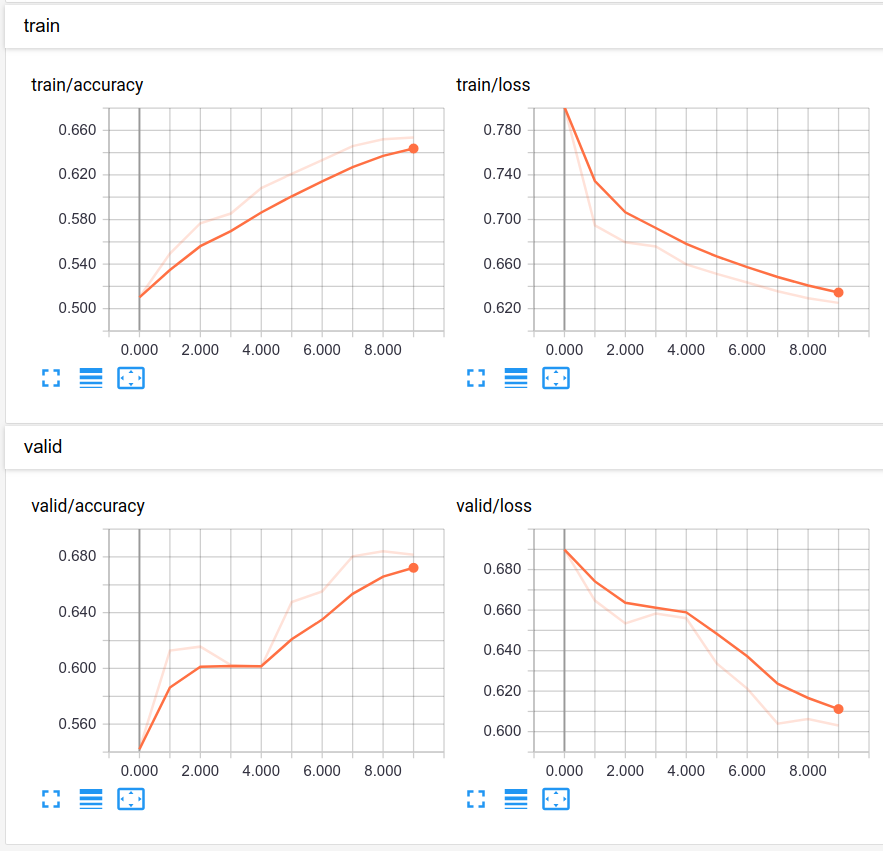

In [9]:
# intialize the model and the hyper-parameters
model = Net()
num_epochs = 10
logs = './all/log/model'
checkpoint = './all/model.pt'
device = torch.device('cuda:0')  # e.g., {'cpu', 'cuda:0', 'cuda:1', ...}
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-4, betas=(0.9, 0.999), weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', factor=0.2, patience=3, verbose=True)

# train the model
best_state = train(model, device, num_epochs, optimizer, train_loader, valid_loader,
                   scheduler, patience=10, load=checkpoint, save=checkpoint, log_dir=logs)
model.load_state_dict(best_state['model'])  # loads the best model acquired during training

### Example conclusion

We implemented a standard deep learning workflow in PyTorch. The steps are (in order):

 - Defined `train_loader` and `valid_loader` that loads and transforms our dataset in batches asynchronously
 - Defined a convolutional neural network called `Net`
 - Implemented `full_epoch()` that does a single training or validation epoch depending on whether it was fed an optimizer
 - Implemented `train()`, that uses `full_epoch()`, with early stopping and nice learning rate scheduling
 - Trained a certain initialization of `Net` with hand-picked hyper-parameters
 - Usually, you would end this by a testing phase (i.e., `test()`) but I will leave that to you because now you know how to do it yourself
 
Final notes and remarks:

 - As an exercise, try to think about how to modify `train()` to handle the case when we don't have validation data (i.e., `valid_loader is None`). You will certainly need to do a descent number of changes to incorporate this.
 - If you want to build an API similar to Keras yourself (although you don't need to because such high-level APIs exist already as mentioned at the beginning of this notebook), you will need to add some parameters to `train()` for callbacks that you call before and after training. Then, put all the early stopping and the learning rate scheduling business outside `train()` by implementing them through these callbacks
 - Please, don't hesitate to contact me by finding me on [GitHub](http://github.com/ModarTensai/) if you have any further inquiries